# Run this in the CLIMADA environment and if you encounter any problems run !pip uninstall pyrepo-mcda

In [9]:
# Install the required package

!pip install pyrepo-mcda

## Part 1: Creating the data frame metrics_df

**Define the enities object to investigate**

In [1]:
# *************** User-modifiable parameters ***************

# Defines the entity and hazard set to be used
# Choose the two following options for the file_str variable, begin with CLIMADA_DEMO:
# 'CLIMADA_DEMO' - CLIMADA demo entity and hazard set TC  (Does not work for Part 4 – Groups)
# 'CanTho_PLFL' - Can Tho, Vietnam and flood hazard (Based on the ECA Case Study ECA Vietnam, Compound Flood Risk and Heat Waves

file_str = 'CanTho_PLFL'   # or 'CLIMADA_DEMO'  'CanTho_PLFL'

# *************** End of user-modifiable parameters ***************


**Load entitites and hazards**

In [3]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.util.api_client import Client
from climada.hazard import Hazard

from MCDM.utils.other_utils import CURRENT_YEAR, FUTURE_YEAR
import copy


## Entities and hazards containers
# Entities should be defined in the following way:
#       1) with a key refering to a reference name, example 'Assets', 'People', 'Infrastructure', or even 'Data_Provider_1' and 'Data_Provider_2'
#       2) and a value being the entity object for the current and future year
# Example: ent_dict = {'Assets': {'today': Entity(), 'future':Entity()},
#                     'People': {'today': Entity(), 'future':Entity()}},
#                     'Infrastructure': {'today': Entity(), 'future':Entity()}}

# Parameters
grwth_rate_dict = {'People': 0.02, 'Assets': 0.02 } # growth rate for the future exposure data

# Load the entities and hazards
if file_str == 'CLIMADA_DEMO':
    ## Entities
    ent_dict = {'Assets': {'today': Entity.from_excel(ENT_DEMO_TODAY), 'future':Entity.from_excel(ENT_DEMO_FUTURE)}}
    ## Hazards
    haz_dict = {'TCs': {'today': Hazard.from_hdf5(HAZ_DEMO_H5), 'future': Hazard.from_hdf5(HAZ_DEMO_H5)}}
    haz_dict['TCs']['future'].intensity *= 1.5 # double the intensity of the future hazard


elif file_str == 'CanTho_PLFL':

    ## Entities
    # Current exposure data - Assets and People
    ent_dict=   {'Assets': {'today': Entity.from_excel('data/Entities/entity_TODAY_CanTho_PLFL_Assets.xlsx')},
                'People': {'today': Entity.from_excel('data/Entities/entity_TODAY_CanTho_PLFL_People.xlsx')}
                }
    # Future exposure data - Assets
    ent_dict['Assets']['future'] = copy.deepcopy(ent_dict['Assets']['today'])
    ent_dict['Assets']['future'].exposures.gdf.value *= (1+grwth_rate_dict['Assets'])**(FUTURE_YEAR-CURRENT_YEAR) # increase the value of the future exposure data given the growth rate
    # Future exposure data - People
    ent_dict['People']['future'] = copy.deepcopy(ent_dict['People']['today'])
    ent_dict['People']['future'].exposures.gdf.value *= (1+grwth_rate_dict['People'])**(FUTURE_YEAR-CURRENT_YEAR) 

    ## Hazards
    # API client
    client = Client()
    # Hazards
    haz_dict = {'river_flood': {'today': client.get_hazard(hazard_type='river_flood', properties={'country_iso3alpha': 'VNM', 'climate_scenario': 'historical'}),
                                'future': client.get_hazard(hazard_type='river_flood', properties={'country_iso3alpha': 'VNM', 'climate_scenario': 'rcp26', 'year_range': '2030_2050'})
                                }
                }




**Genereate the metrics data frame**

In [5]:
from MCDM.utils.other_utils import generate_metrics, RISK_FNCS_DICT # Import the risk functions dictionary (default risk functions are defined in the utils.py file)
import pandas as pd
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_df = pd.read_csv(f'data/Metrics/{file_str}.csv')
except:
    #%% Generate metrics dataframe
    metrics_df = generate_metrics(haz_dict, ent_dict, risk_fncs_dict = RISK_FNCS_DICT, file_output = file_str)

    # Add additional fictive metrics to the dataframe - APPROV and FEAS
    temp_df = pd.DataFrame(metrics_df['measure'].unique(), columns=['measure'])
    temp_df['approv'] = [np.random.randint(1, 5) for _ in range(len(temp_df))]
    temp_df['feas'] = np.random.rand(len(temp_df))
    extra_metrics_df = pd.merge(metrics_df, temp_df, on='measure')

# Clear the cell output to avoid output from the print statement when calling the cost-benefit calculation  
# However, if intrested in the output, comment the following line
clear_output()

# Print the first few rows of the dataframe
print(f'Metrics in the {file_str} file')
print('---------------------------')
print(tabulate(metrics_df.head(), headers='keys', tablefmt='psql'))
# Get all the columns of the dataframe ben_ or bcr_ or npv_ + RISK_FNCS_DICT.keys() + ent_dict.keys()
all_crit_cols = [col for col in metrics_df.columns if 'ben_' in col or 'bcr_' in col or 'npv_' in col or 'approv' in col or 'cost' in col or 'feas' in col]
print(f'The criteria columns of the metrics dataframe are: \n{all_crit_cols}')
print('---------------------------')




Metrics in the CanTho_PLFL file
---------------------------
+----+-----------------+-------------+------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------+
|    | measure         | hazard      | haz_type   |   cost_Assets |   cost_People |   ben_aai_Assets |   ben_aai_People |   bcr_aai_Assets |   bcr_aai_People |   npv_aai_Assets |   npv_aai_People |   ben_rp250_Assets |   ben_rp250_People |   bcr_rp250_Assets |   bcr_rp250_People |   npv_rp250_Assets |   npv_rp250_People |   approv |     feas |
|----+-----------------+-------------+------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+---------

**Description metrics – Criteria of choice**

| Metric            | Description                                                         | Objective | Example Utility |
|-------------------|---------------------------------------------------------------------|-----------|-----------------|
| cost_Assets       | Discounted cost of the measure given by entity named "Assets"                          | Minimize  |                 |
| ben_aai_Assets    | Averted risk in comparison to no measure, based on avg. annual impact             | Maximize  | Identifies cost-effective measures. Usefule for excluding, i.e., filtering, non-cost-efficient measures.|
| bcr_aai_Assets    | Benefit-to-cost ratio, based on avg. annual impact                  | Maximize  |                 |
| npv_aai_Assets    | Total NPV of risk, with measure, based on avg. annual impact        | Minimize  | Enables identification of intolerable risk levels, such as assets or populations remaining at risk. |
| ben_rp250_Assets  | Averted risk in comparison to no measure, based on 250-year return period         | Maximize  | Highlights measures reducing extreme risk |
| bcr_rp250_Assets  | Benefit-to-cost ratio, based on 250-year return period              | Maximize  |                 |
| npv_rp250_Assets  | Total NPV of risk, with measure, based on 250-year return period    | Minimize  |                 |
| approv            | Criteria values representing public approval                        | Maximize  |                 |
| feas              | Criteria values representing feasibility                            | Maximize  |                 |


# Part 2: Ranking the alternatives

#### Initialize the decision matrix object and rank 

The available alternatives are:
---------------------------
+----+------------------+--------------------------+
|    | Alternative ID   | measure                  |
|----+------------------+--------------------------|
|  0 | A1               | Flood Awareness          |
|  1 | A2               | Flood Wall               |
|  2 | A3               | Green Roofs              |
|  3 | A4               | Green Spaces             |
|  4 | A5               | Insurance                |
|  5 | A6               | Mobile flood embankments |
|  6 | A7               | Rain collection          |
|  7 | A8               | Rehabilitation Drainage  |
|  8 | A9               | Retention Reservoirs     |
|  9 | A10              | Spillways                |
| 10 | A11              | Storage + Sandbags       |
| 11 | A12              | Swales                   |
| 12 | A13              | Waste Management         |
| 13 | A14              | no measure               |
+----+------------------+--------------

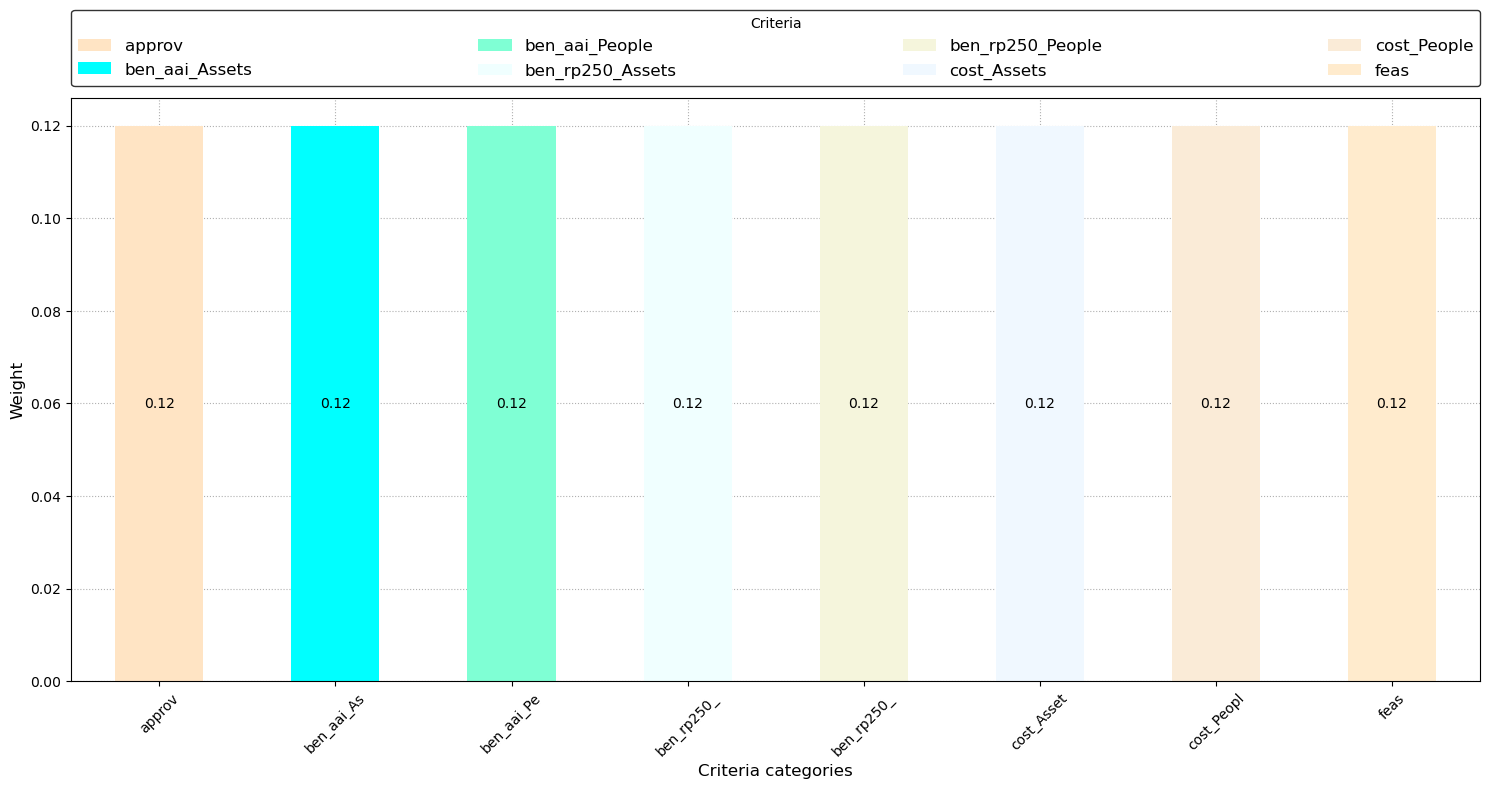

In [6]:
from MCDM.DecisionMatrix import DecisionMatrix  # Import DecisionMatrix module

# *************** User-modifiable parameters ***************

alt_cols = ['measure'] # Columns in metrics_df that contains the alternatives
crit_cols = [col for col in all_crit_cols if 'bcr' not in col and 'npv' not in col] # Columns in metrics_df that contains the criteria
objectives = {crit: -1 if 'cost' in crit else 1 for crit in crit_cols} # Dictionary of objectives
weights = {} # Dictionary of weights. Default is equal for all criteria

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols)

# Print the alternatives
print('The available alternatives are:')
print('---------------------------')
print(tabulate(dm.alternatives_df, headers='keys', tablefmt='psql'))

# Plot the criteria weights
dm.plot_criteria_weights()

# Rank the alternatives
ranks_output = dm.calc_rankings()

**Display the rankings only for the individual criteria, excluding the MCDM rankings**

The performance of the alternatives based on each criteria is:
---------------------------
+------------------+--------------------------+---------------+---------------+------------------+------------------+--------------------+--------------------+----------+--------+
| Alternative ID   | measure                  |   cost_Assets |   cost_People |   ben_aai_Assets |   ben_aai_People |   ben_rp250_Assets |   ben_rp250_People |   approv |   feas |
|------------------+--------------------------+---------------+---------------+------------------+------------------+--------------------+--------------------+----------+--------|
| A1               | Flood Awareness          |             6 |             6 |                4 |                4 |                  1 |                  1 |        1 |      6 |
| A2               | Flood Wall               |            12 |            12 |                2 |                2 |                  8 |                  6 |        1 |      5 |
| A3     

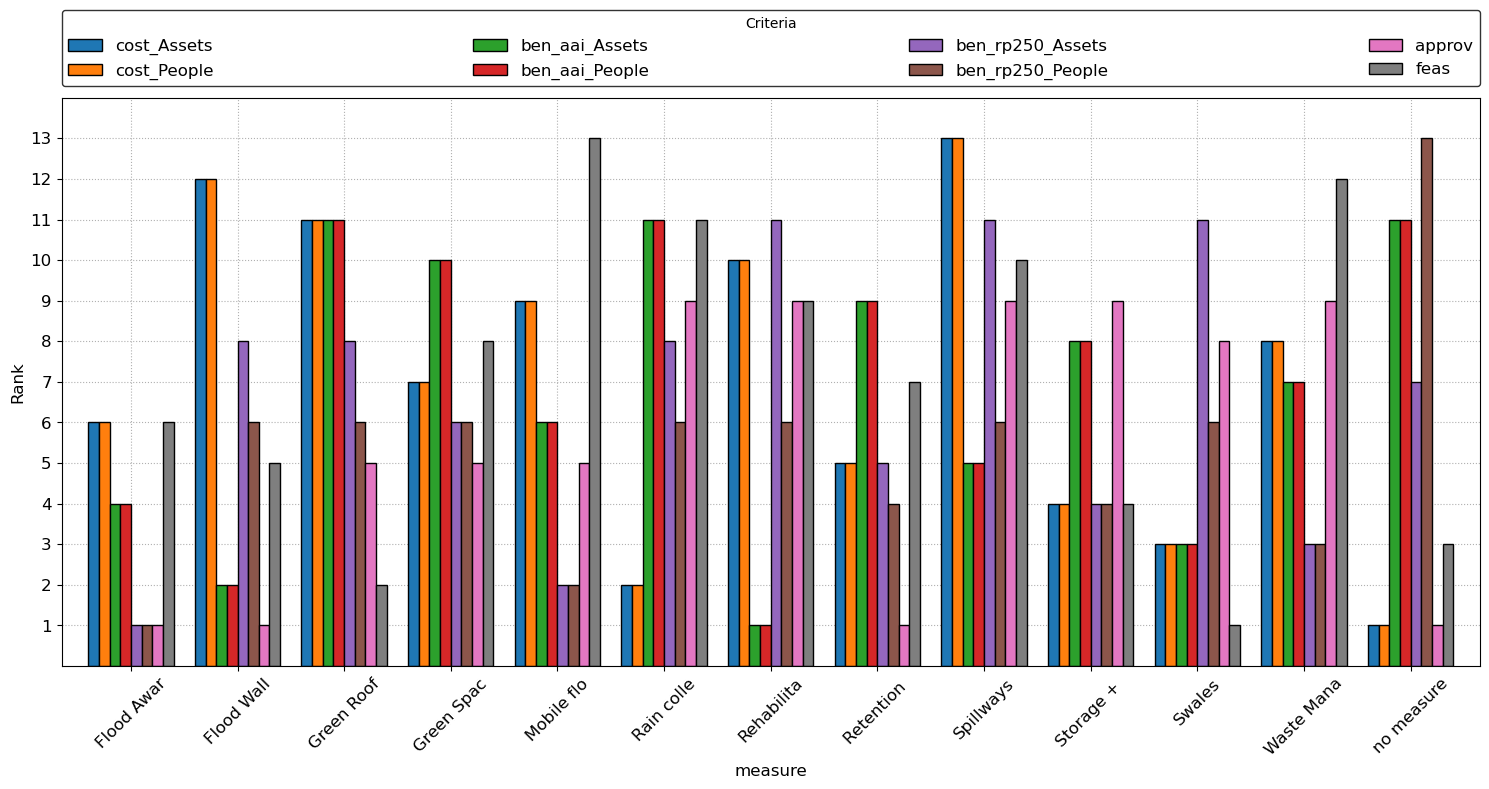

In [7]:
print('The performance of the alternatives based on each criteria is:')
print('---------------------------')
# Print the rankings - Criteria
ranks_output.print_rankings(rank_type='criteria')
print('---------------------------')
print('Is any alternative clearly dominating the others?')
# Plot the rankings -Criteria
ranks_output.plot_ranks( alt_name_col = 'measure', rank_type='criteria')

**Display the rankings of the MCDM methods**



| Method (Full Name)             | Approach & Application                                                                                                    | Decision Maker's Risk Profile                                                                                                                      |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| Simple Additive Weighting (SAW) | Additive weighting: SAW simply adds up the normalized values for each criterion, after multiplying them by their respective weights. This method is straightforward and works well when all criteria are well-understood and can be quantifiably expressed, making it an attractive choice for decision-makers who prefer clarity and simplicity in their evaluation process. | Ideal for decision-makers who value straightforward evaluations and are comfortable with decisions where the criteria are well-understood and quantifiable. |
| Technique for Order of Preference by Similarity to Ideal Solution (TOPSIS) | Distance-based evaluation: TOPSIS assesses alternatives by determining their proximity to the most desirable (ideal) scenario and their distance from the least desirable (anti-ideal) scenario. It suits decision-makers who aim for a balanced approach, seeking an alternative that performs well across all considered criteria, thereby reflecting a moderate aversion to unfavorable outcomes. | Suited for those who seek a balanced solution that is as good as possible across all criteria, showing a moderate aversion to outcomes that are far from the best possible scenario. |
| VIKOR | Compromise solution: VIKOR seeks an alternative that provides the best compromise between the ideal and the least desirable outcomes across all criteria. It's particularly effective for decision-makers inclined towards caution, aiming to ensure that selected options do not deviate significantly from acceptable standards in any of the considered aspects. | Perfect for cautious decision-makers looking to minimize exposure to the worst outcomes in any criterion, ensuring no option is too far from an acceptable outcome. |
| Copeland (Ensemble Approach) | Ensemble ranking: The Copeland method synthesizes insights from multiple MCDM methods by conducting pairwise comparisons among alternatives, culminating in a unified ranking. This method is especially useful for integrating diverse perspectives, thus reducing the impact of specific biases or limitations associated with individual decision-making frameworks. | This approach balances various risk profiles, integrating insights from multiple methods to reduce sensitivity to any one method's parameters or weights. |


The performance of the alternatives given by the MCDM methods is:
---------------------------
+------------------+--------------------------+----------+-------+---------+------------+
| Alternative ID   | measure                  |   Topsis |   Saw |   Vikor |   copeland |
|------------------+--------------------------+----------+-------+---------+------------|
| A1               | Flood Awareness          |        1 |     1 |       1 |          1 |
| A12              | Swales                   |        2 |     5 |       2 |          2 |
| A14              | no measure               |        3 |     2 |       4 |          2 |
| A8               | Rehabilitation Drainage  |        4 |     4 |       5 |          3 |
| A2               | Flood Wall               |        5 |     3 |       6 |          4 |
| A9               | Retention Reservoirs     |        6 |     8 |       3 |          5 |
| A6               | Mobile flood embankments |        7 |     6 |       7 |          6 |
| A11 

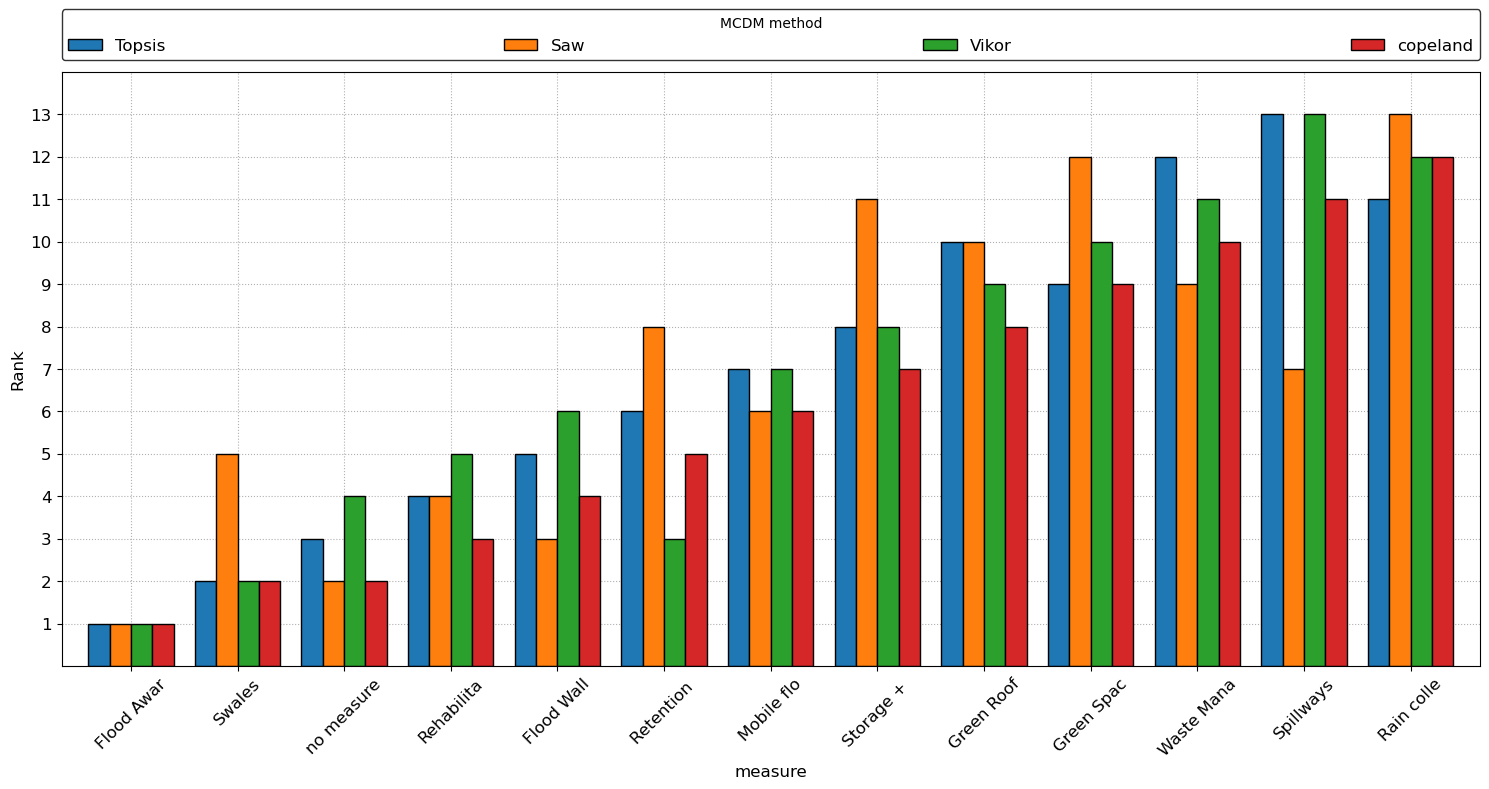

In [8]:
print('The performance of the alternatives given by the MCDM methods is:')
print('---------------------------')
# Print the rankings - MCDM methods
ranks_output.print_rankings(rank_type='MCDM', sort_by_col='copeland')
# Plot the rankings - MCDM methods
ranks_output.plot_ranks(alt_name_col = 'measure', rank_type='MCDM', sort_by_col='copeland', transpose=False)

#### Customized ranking methods

Table below shows the excluded alternatives, i.e., not satifying constraints,
where True if particular constraint is satisfied and False if not. 
.
.
+----+------------------+-----------------+------------------+-------+
|    | Alternative ID   | measure         | ben_aai_Assets   | bcr   |
|----+------------------+-----------------+------------------+-------|
|  0 | A3               | Green Roofs     | False            | False |
|  1 | A4               | Green Spaces    | True             | False |
|  2 | A7               | Rain collection | False            | False |
|  3 | A14              | no measure      | False            | False |
+----+------------------+-----------------+------------------+-------+


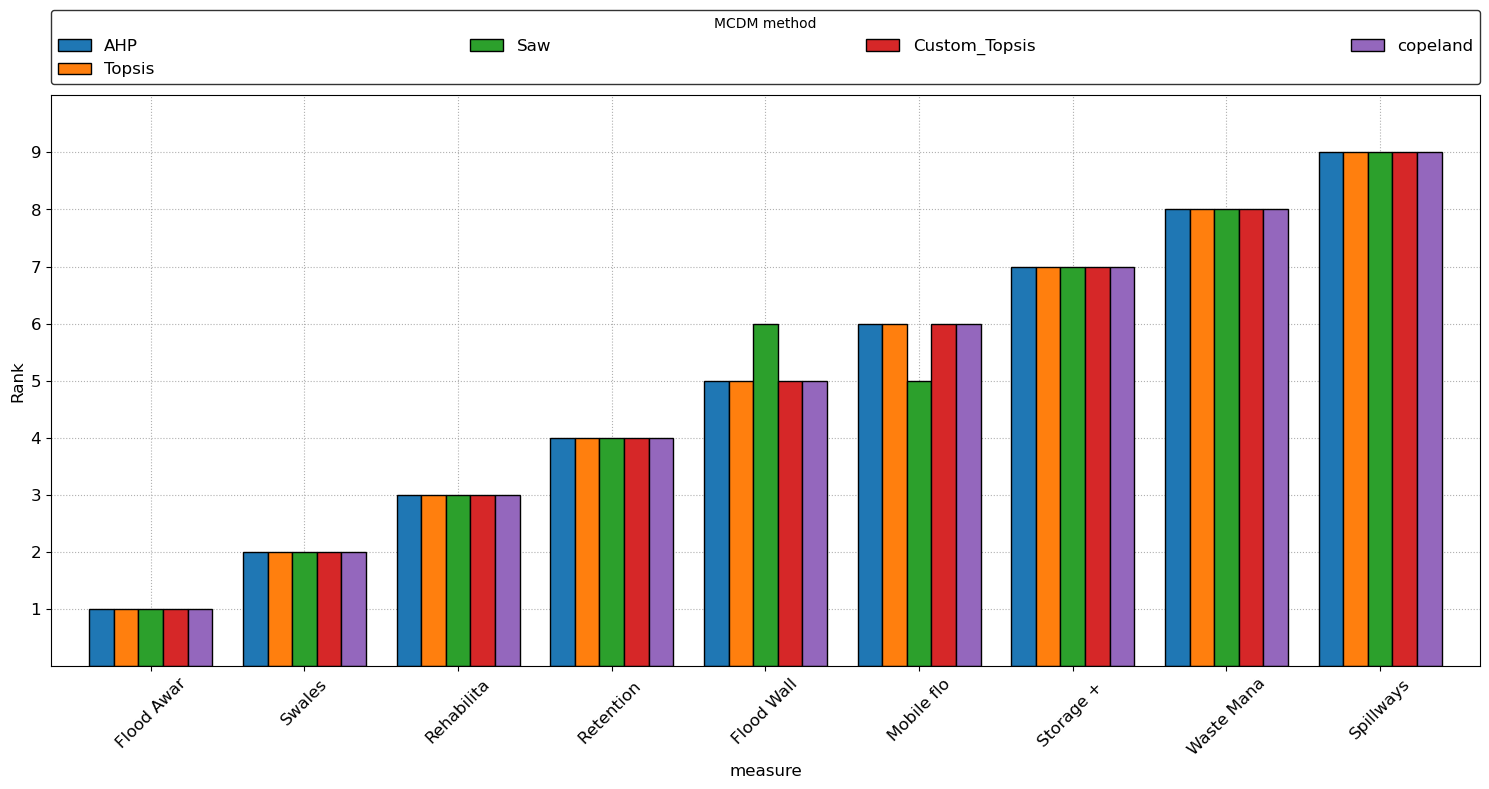

In [9]:
# Define the MCDM ranking methods
from pyrepo_mcda.mcda_methods import AHP, TOPSIS, SAW, VIKOR #  SPOTIS, ARAS, COCOSO, CODAS, COPRAS, CRADIS, EDAS, MABAC, MARCOS, MULTIMOORA, MULTIMOORA_RS, PROMETHEE_II, PROSA_C,, VMCM, WASPAS, VIKOR_SMAA
from pyrepo_mcda.compromise_rankings import copeland, dominance_directed_graph, rank_position_method
from pyrepo_mcda import distance_metrics as dists
from pyrepo_mcda import normalizations as norms


# *************** User-modifiable parameters ***************

# Define the MCDM ranking methods
mcdm_methods = {'AHP': AHP(), # Analytic Hierarchy Process default parameters
          'Topsis': TOPSIS(), # Technique for Order Preference by Similarity to Ideal Solution default parameters
          'Saw': SAW(), # Simple Additive Weighting default parameters
          'Custom_Topsis': TOPSIS(normalization_method = norms.minmax_normalization, distance_metric = dists.euclidean) # Custom method with customized normalization and distance methdods
    }

# Define the compromised ranking function of the rank matrices
comp_ranks = {'copeland': copeland,
      }

# Dictionary of derived columns and their functions
derived_columns = {'bcr': lambda df: df['ben_aai_Assets']/df['cost_Assets']}

# Apply a constraint to the decision matrix
# You find the filter definition in the utils.py file in the function filter_df
constraints = {'ben_aai_Assets': {'greater': 0},
                 # 'cost_Assets': {'less': 5000000},
                  'bcr': {'greater': 1} # Benefit-cost ratio greater than 1 (Given the derived column above, this is equivalent to the benefit being greater than the cost)
                  }

# *************** End of user-modifiable parameters ***************


# Calculate the rankings
ranks_output = dm.calc_rankings( mcdm_methods, comp_ranks, constraints=constraints, derived_columns=derived_columns)
clear_output()


# Check if ranks_output has an attribute alt_exc_const_df
if hasattr(ranks_output, 'alt_exc_const_df'):
    # Print the alternatives that do not satisfy the constraints
    print("Table below shows the excluded alternatives, i.e., not satifying constraints,\nwhere True if particular constraint is satisfied and False if not.", 2*"\n.")
    print(tabulate(ranks_output.alt_exc_const_df, headers='keys', tablefmt='psql'))

# Plot the rankings
ranks_output.plot_ranks(disp_rnk_cols=[], rank_type='MCDM', sort_by_col='copeland', transpose=False, alt_name_col='measure')


## Part 3 – Weight sensitivities and preferences 

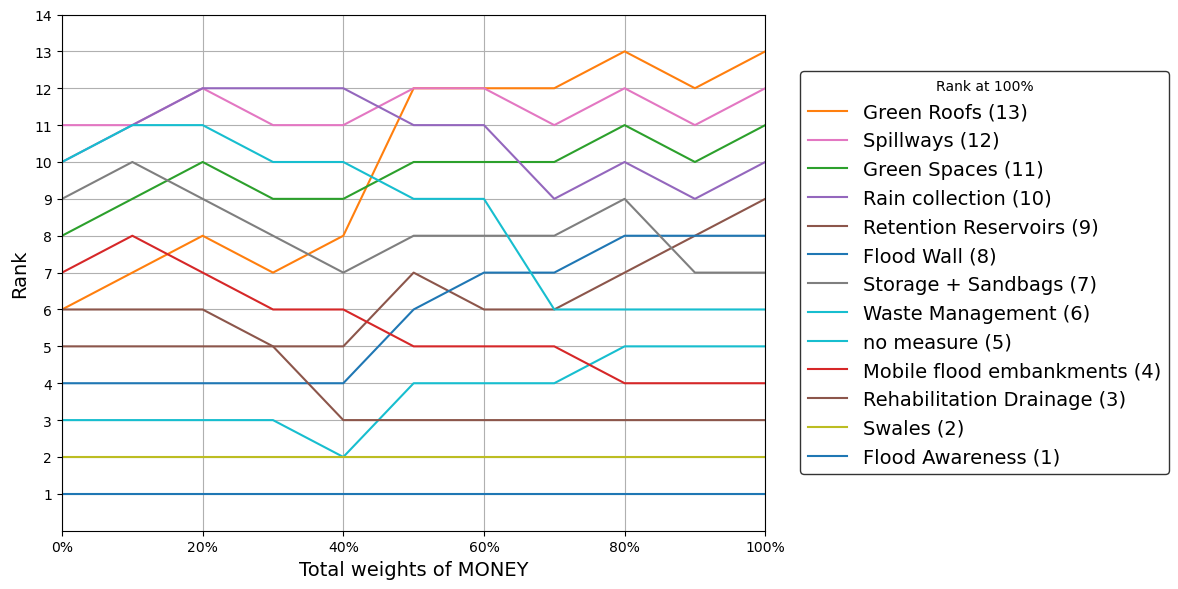

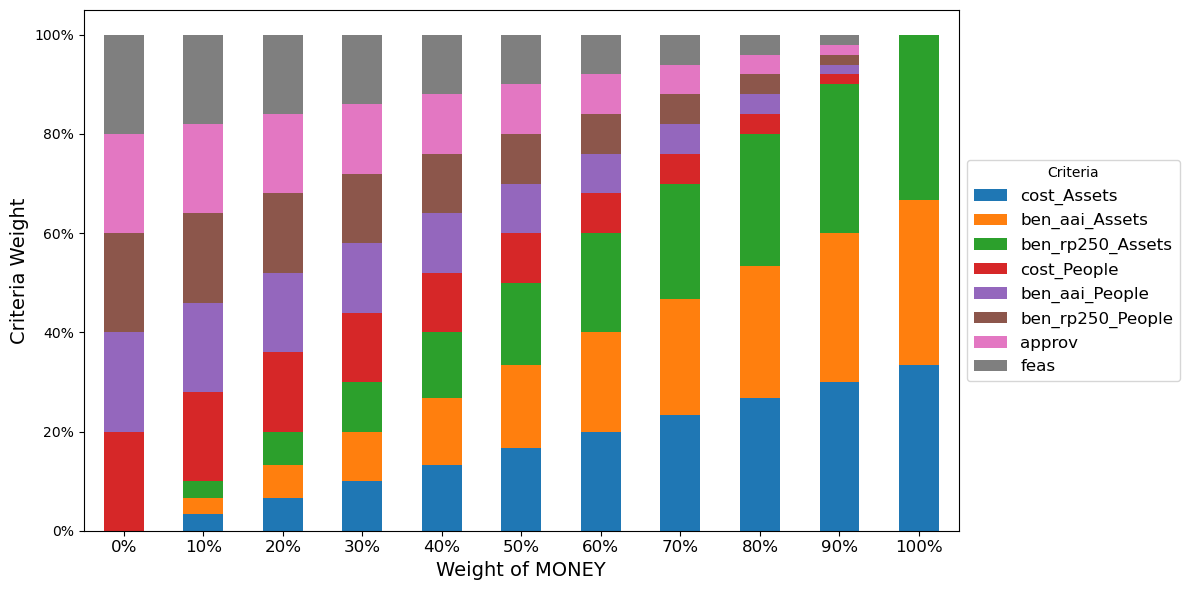

In [10]:
# *************** User-modifiable parameters ***************

crit_cols_dict = {'MONEY': ['cost_Assets','ben_aai_Assets', 'ben_rp250_Assets']} # Dictionary of criteria categories and their criteria columns

# *************** End of user-modifiable parameters ***************

# Calculate the sensitivity of the rankings to the weights of the criteria
sensitivity_df = dm.calc_imprt_sensitivity(crit_cols_dict=crit_cols_dict, mcdm_methods=mcdm_methods, comp_ranks=comp_ranks, alt_tag='measure')

**Criteria categories**

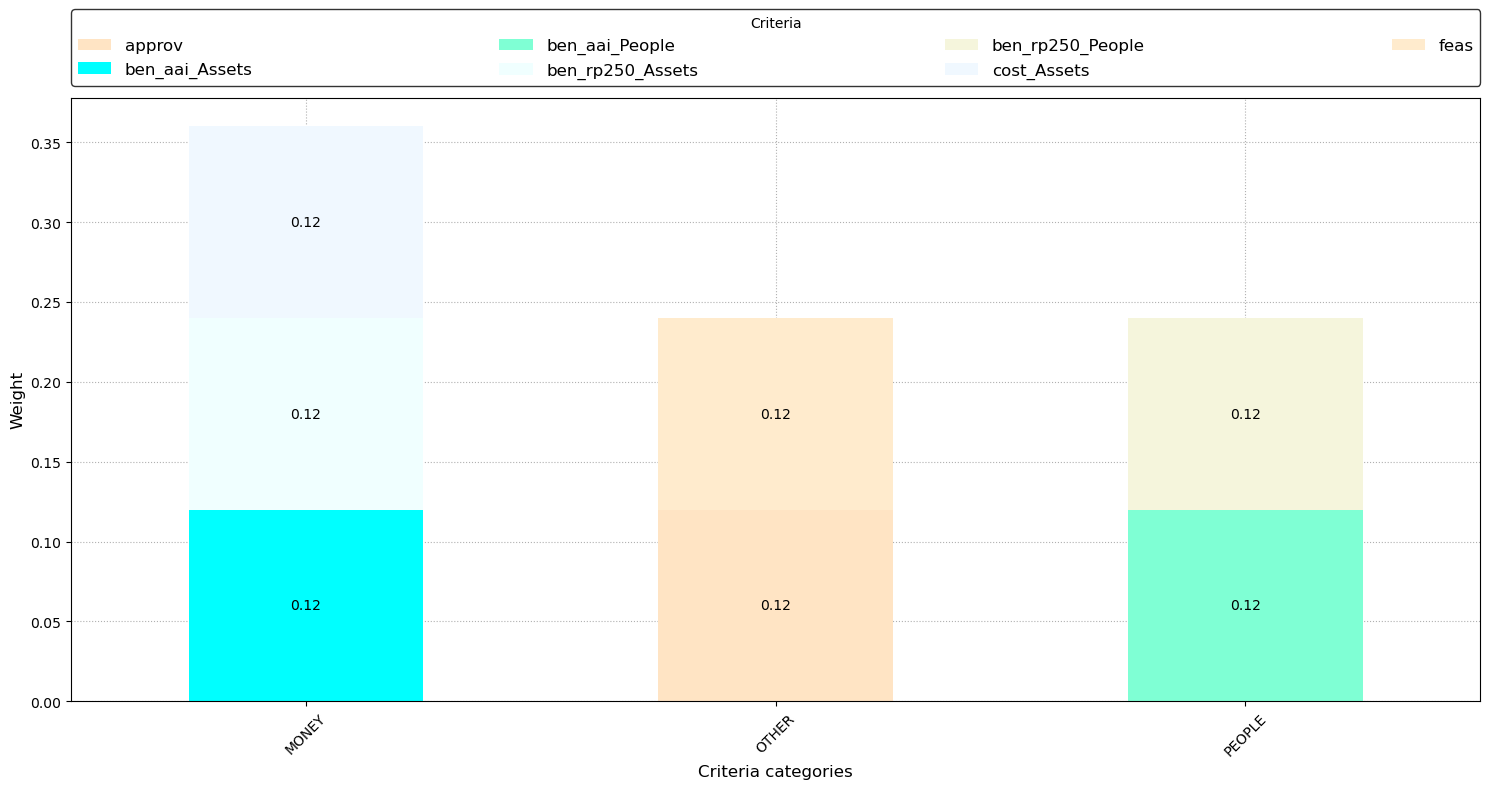

In [11]:
# Initialize the decision matrix object and include more criteria

# categorize the criteria assets and people
crit_cats = {'MONEY': ['ben_aai_Assets',  'ben_rp250_Assets', 'cost_Assets'],
             'PEOPLE': ['ben_aai_People', 'ben_rp250_People'],
             'OTHER': ['approv', 'feas']}


# Initialize the decision matrix object
dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, crit_cats=crit_cats)

# Plot the criteria weights
dm.plot_criteria_weights(group_by_category=True)

**Weight helpers – Pairwise comparison**

If you want some assistance on how to calculate the weights using the Analytic Hierarchy Process (AHP) method:

*"The Analytic Hierarchy Process (AHP) calculates weights by comparing elements pairwise in terms of their relative importance. First, decision-makers assess each pair using a scale (e.g., 1 to 9), which reflects how much more important one element is over another. These judgments populate a comparison matrix, where each element’s relative importance is quantified. The matrix is then normalized (typically by dividing each value by its column sum), and the average of each row provides the weight for each element. This process ultimately yields a set of priority weights that reflect the relative importance of each element."*

## Part 3 - Incorporating uncertainties

**Define the uncertainty variables**

In [13]:
# Uncertainty variables
import scipy as sp

# *************** User-modifiable parameters ***************

# Do not modify the function names, e.g, ent_today_func!!!

# Uncertainty variable distributions
unc_var_dist_dict = {"x_ent": sp.stats.uniform(0.7, 1),
                     "m_fut_cost": sp.stats.norm(1, 0.1),
                     "x_haz_today": sp.stats.uniform(1, 3),
                     "x_haz_fut": sp.stats.uniform(1, 3)}

# Base functions
# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    entity = copy.deepcopy(ent_today_base)
    entity.exposures.ref_year = CURRENT_YEAR
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    entity = copy.deepcopy(ent_today_base)
    entity.exposures.ref_year = FUTURE_YEAR
    for meas in entity.measures.get_measure(haz_today_base.haz_type):
        meas.cost *= m_fut_cost
    return entity

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_today_func(x_haz_today, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    haz = copy.deepcopy(haz_today_base)
    haz.intensity = haz.intensity.multiply(x_haz_today)
    return haz

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    haz = copy.deepcopy(haz_fut_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz

# *************** End of user-modifiable parameters ***************


**Generate the metrics data frame**

In [15]:
from MCDM.utils.other_utils import generate_unc_func_dist_dict

# Creaate the uncertainty functions dictionary input variable
unc_func_dist_dict = generate_unc_func_dist_dict(func_dict= {'ent_today': ent_today_func, 'ent_fut': ent_fut_func, 'haz_today': haz_today_func, 'haz_fut': haz_fut_func}, unc_var_dist_dict= unc_var_dist_dict)

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_unc_df = pd.read_csv('data/Metrics/{}.csv'.format(file_str + '_unc'))
except:
    #%% Generate metrics dataframe
    if file_str == 'CLIMADA_DEMO':
        n_samples = 100
    else:
        n_samples = 1 # You can increase the number of samples but very slow for the CanTho_PLFL case

    # Generate the metrics dataframe
    metrics_unc_df = generate_metrics(haz_dict, ent_dict, unc_func_dist_dict = unc_func_dist_dict, risk_fncs_dict = RISK_FNCS_DICT, n_samples= n_samples, future_year=FUTURE_YEAR, current_year=CURRENT_YEAR, file_output = file_str + '_unc')


# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
clear_output()

# Print the first few rows of the dataframe
print("\n.", "Table below shows the first few rows of the dataframe with the uncertainty samples.", 2*"\n.")
print(tabulate(metrics_unc_df.head(), headers='keys', tablefmt='psql'))


. Table below shows the first few rows of the dataframe with the uncertainty samples. 
.
.
+----+-----------------+-------------+------------+---------+--------------+---------------+-------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+
|    | measure         | hazard      | haz_type   |   x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   ben_aai_Assets |   ben_aai_People |   bcr_aai_Assets |   bcr_aai_People |   npv_aai_Assets |   npv_aai_People |   ben_rp250_Assets |   ben_rp250_People |   bcr_rp250_Assets |   bcr_rp250_People |   npv_rp250_Assets |   npv_rp250_People |   cost_Assets |   cost_People |   approv |     feas |
|----+-----------------+-------------+------------+---------+--------------+---------------+-------------+

**Calculate and display the ranks**

In [16]:
# *************** User-modifiable parameters ***************

# Define the uncertainty variables
unc_cols = [key for key in unc_var_dist_dict] # Columns in metrics_df that contains the uncertainty variables

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm_unc = DecisionMatrix(metrics_df=metrics_unc_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, unc_cols=unc_cols)

# Rank the alternatives
ranks_output_unc = dm_unc.calc_rankings()
clear_output()

# Print the sample dataframe (first few rows)
print("\n.", "Table below shows the dataframe with the unique uncertainty samples.", 2*"\n.")
print("_"*100)
print(tabulate(dm_unc.metrics_df.head(), headers='keys', tablefmt='psql'))





. Table below shows the dataframe with the unique uncertainty samples. 
.
.
____________________________________________________________________________________________________
+----+-----------------+-------------+------------+---------+--------------+---------------+-------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+---------------+----------+----------+
|    | measure         | hazard      | haz_type   |   x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   ben_aai_Assets |   ben_aai_People |   bcr_aai_Assets |   bcr_aai_People |   npv_aai_Assets |   npv_aai_People |   ben_rp250_Assets |   ben_rp250_People |   bcr_rp250_Assets |   bcr_rp250_People |   npv_rp250_Assets |   npv_rp250_People |   cost_Assets |   cost_People |   approv |     feas |
|----+--------------

**Display the results**

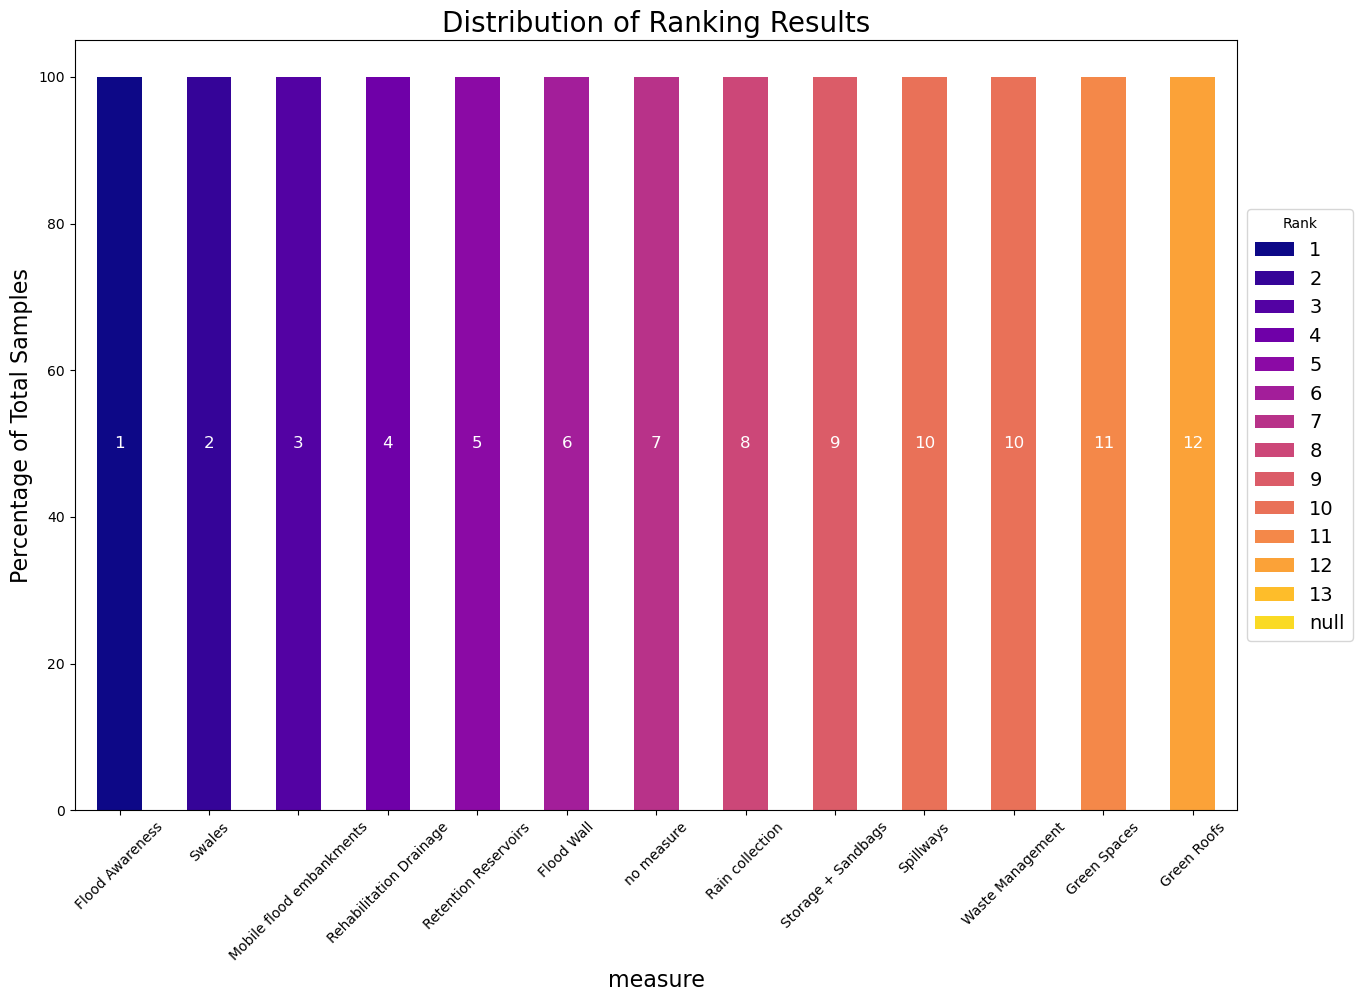

In [17]:
# Plot the rankings
ranks_output_unc.plot_rank_distribution(disp_rnk_col='copeland', alt_name_col='measure')

**Look at samples where each measure performs well and poor**

*Note: This analysis can be enhanced by integrating with the 'unsequa' module to explore how ranking sensitivities and different "scenarios" — sets of uncertainty variables — affect the performance of each alternative, both positively and negatively.e*    

In [18]:
# Print the top and bottom 5 alternatives for each measure
for measure in ranks_output_unc.ranks_MCDM_df['measure'].unique():
    # Filter the dataframe for the current measure
    measure_df = ranks_output_unc.ranks_MCDM_df[ranks_output_unc.ranks_MCDM_df['measure'] == measure]
    # Drop the Group ID column
    measure_df.drop(columns='Group ID', inplace=True)

    # Sort the filtered dataframe on the 'copeland' column
    measure_df.sort_values(by='copeland', ascending=True, inplace=True)

    # Print the top 5 performance
    print(f"The top 5 sample ID for the measure {measure} are:")
    print(tabulate(measure_df.head(5), headers='keys', tablefmt='psql'))

    # Print the bottom 5 performance
    print(f"The bottom 5 sample ID for the measure {measure} are:")
    print(tabulate(measure_df.tail(5), headers='keys', tablefmt='psql'))

    print('---------------------------')
    print("\n.")


The top 5 sample ID for the measure Flood Awareness are:
+----+------------------+-----------------+-------------+---------+--------------+---------------+-------------+----------+-------+---------+------------+
|    | Alternative ID   | measure         | Sample ID   |   x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   Topsis |   Saw |   Vikor |   copeland |
|----+------------------+-----------------+-------------+---------+--------------+---------------+-------------+----------+-------+---------+------------|
|  0 | A1               | Flood Awareness | S1          | 1.16875 |      1.04023 |       1.28125 |     2.40625 |        1 |     1 |       2 |          1 |
| 13 | A1               | Flood Awareness | S2          | 1.16875 |      1.04023 |       1.28125 |     2.59375 |        1 |     1 |       2 |          1 |
| 26 | A1               | Flood Awareness | S3          | 1.16875 |      1.04023 |       1.84375 |     2.40625 |        1 |     1 |       2 |          1 |
| 39 | A1    

**Filter out specific samples to rank**

In [19]:
# *************** User-modifiable parameters ***************

# Define the condition
rank_filt = {'m_fut_cost': {'range': (1.0, 1.05)}
              # 'x_haz_today': {'greater': 2.8}
               }

# *************** End of user-modifiable parameters ***************

# Rank the alternatives
filt_ranks_output_unc = dm_unc.calc_rankings(rank_filt=rank_filt)

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
clear_output()

# Print the rankings
filt_ranks_output_unc.print_rankings()



State: S1
-----------------------------------
+------------------+--------------------------+---------+--------------+---------------+-------------+----------+-------+---------+------------+
| Alternative ID   | measure                  |   x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   Topsis |   Saw |   Vikor |   copeland |
|------------------+--------------------------+---------+--------------+---------------+-------------+----------+-------+---------+------------|
| A1               | Flood Awareness          | 1.16875 |      1.04023 |       1.28125 |     2.40625 |        1 |     1 |       2 |          1 |
| A2               | Flood Wall               | 1.16875 |      1.04023 |       1.28125 |     2.40625 |        7 |     5 |       7 |          6 |
| A3               | Green Roofs              | 1.16875 |      1.04023 |       1.28125 |     2.40625 |       13 |    12 |      13 |         12 |
| A4               | Green Spaces             | 1.16875 |      1.04023 |       1.281

**Derive (new) criteria as the conditional mean**  

*This approach is useful for analyzing specific scenarios, i.e., sets of uncertainty variables.*

The plot below shows the rankings of the alternatives based on the conditional mean of the criteria. 
.
.
+------------------+--------------------------+-------+----------+-------+-----------------+------------+
| Alternative ID   | measure                  |   AHP |   Topsis |   Saw |   Custom_Topsis |   copeland |
|------------------+--------------------------+-------+----------+-------+-----------------+------------|
| A1               | Flood Awareness          |     1 |        1 |     1 |               1 |          1 |
| A12              | Swales                   |     2 |        2 |     3 |               2 |          2 |
| A6               | Mobile flood embankments |     3 |        3 |     6 |               3 |          3 |
| A8               | Rehabilitation Drainage  |     4 |        4 |     4 |               4 |          4 |
| A9               | Retention Reservoirs     |     5 |        5 |     8 |               5 |          5 |
| A2               | Flood Wall               

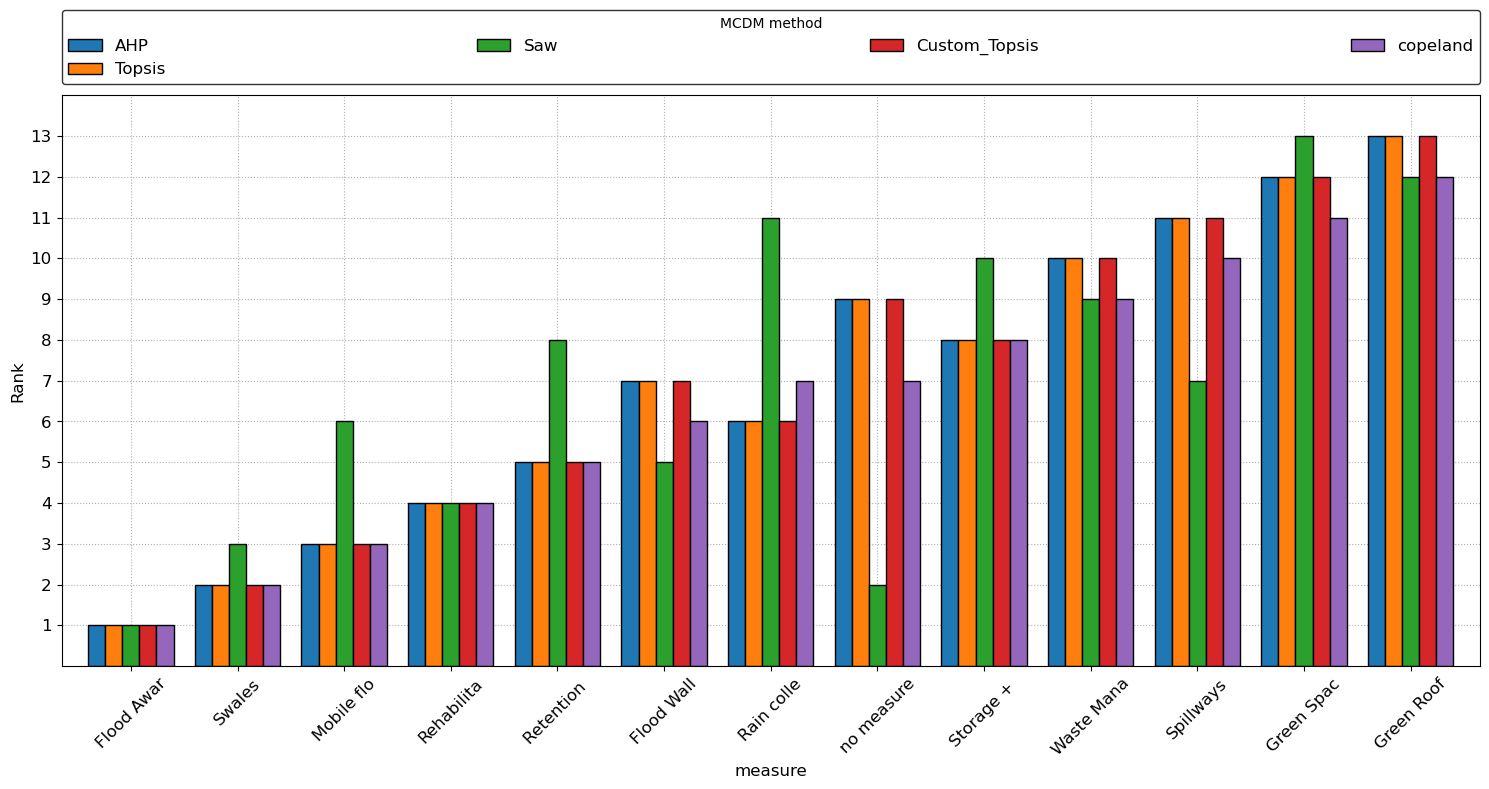

In [20]:
# *************** User-modifiable parameters ***************

# Define the condition
condition = {'m_fut_cost': {'greater': 1} # The future cost of the adaptation measures is greater than 1
                  }

# *************** End of user-modifiable parameters ***************

# Calculate the conditional mean based criteria
dm_cond_unc_mean = dm_unc.mean_based_criteria(condition=condition)

# Calculate the rankings
rnks_cond_unc_mean = dm_cond_unc_mean.calc_rankings( mcdm_methods, comp_ranks)

# Plot the rankings
print("The plot below shows the rankings of the alternatives based on the conditional mean of the criteria.", 2*"\n.")
rnks_cond_unc_mean.print_rankings(sort_by_col='copeland')
rnks_cond_unc_mean.plot_ranks(sort_by_col='copeland', alt_name_col='measure')

## Part 4 - Considering Groups (Only works for file_str = 'CanTho_PLFL': Go back to Part 1)

In [21]:
# If you look at the entities exposure object, you will see that the exposure geodataframe has a description column "admin1_info"

# Print the first few rows of the exposure geodataframe
print(tabulate(ent_dict['Assets']['today'].exposures.gdf.head(), headers='keys', tablefmt='psql'))

# Print the unique set of groups in admin1_info
print("The unique set of groups in the admin1_info column is:")
print(ent_dict['Assets']['today'].exposures.gdf.admin1_info.unique())


+----+---------------+---------+--------------+----------+-----------+---------------+-----------+-----------+-------------------------------------+
|    |   category_id |   value | value unit   | legend   |   impf_RF | admin1_info   |   impf_FL |   impf_HW | geometry                            |
|----+---------------+---------+--------------+----------+-----------+---------------+-----------+-----------+-------------------------------------|
|  0 |           201 | 13759.2 | USD          | Housing  |       201 | Hau Giang     |       201 |       201 | POINT (105.720802077 10.0041756946) |
|  1 |           201 | 20638.8 | USD          | Housing  |       201 | Hau Giang     |       201 |       201 | POINT (105.719997541 10.0045494946) |
|  2 |           201 |  6879.6 | USD          | Housing  |       201 | Hau Giang     |       201 |       201 | POINT (105.719951268 10.0045046032) |
|  3 |           201 |  1985.6 | USD          | Housing  |       201 | Hau Giang     |       201 |       2

**Calc the metrics for each group**

In [23]:
# Generate the metrics dataframe but with the admin1_info column as a group column

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_group_df = pd.read_csv('data/Metrics/{}.csv'.format(file_str + '_group'))
except:
    #%% Generate metrics dataframe
    metrics_group_df = generate_metrics(haz_dict, ent_dict, groups = ['admin1_info'], risk_fncs_dict = RISK_FNCS_DICT, future_year=FUTURE_YEAR, current_year=CURRENT_YEAR, file_output = file_str + '_group')

# Filter out the 'ALL' group which is simply the the exposure data for the entire region
metrics_group_df = metrics_group_df[metrics_group_df['admin1_info'] != 'ALL']
# ALso filter out the 'unknown' group to make the graph more readable
metrics_group_df = metrics_group_df[metrics_group_df['admin1_info'] != 'unknown']


**Initialize the dm object**

In [24]:
# *************** User-modifiable parameters ***************

# Define the internal group weights (default is equal if none is defined) which should sum to 1
group_weights = {'admin1_info': {'Vĩnh Long': 0.7, 'Hau Giang': 0.3}}

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm_groups = DecisionMatrix(metrics_df=metrics_group_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols,
                           group_cols=['admin1_info'], group_weights= group_weights )

# Print the groups
print(2*'.\n')
print('The available groups and the internal group weights for the specific group are:')
print('---------------------------')
print(tabulate(dm_groups.group_weights['admin1_info'], headers='keys', tablefmt='psql'))

.
.

The available groups and the internal group weights for the specific group are:
---------------------------
+----+---------------+----------+
|    | admin1_info   |   Weight |
|----+---------------+----------|
|  1 | Hau Giang     |      0.3 |
|  2 | Vĩnh Long     |      0.7 |
+----+---------------+----------+


**Calc ranks for each group**

In [25]:
# You can either look at the rankings of the alternatives for each group or the rankings of the groups themselves
# Rank the alternatives
ranks_output = dm_groups.calc_rankings()

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
# However, if intrested in the output, comment the following line
clear_output()

# Print the rankings
print('The performance of the alternatives for each group based on the criteria is:')
ranks_output.print_rankings()



The performance of the alternatives for each group based on the criteria is:
Group: G1
-----------------------------------
+------------------+--------------------------+---------------+----------+-------+---------+------------+
| Alternative ID   | measure                  | admin1_info   |   Topsis |   Saw |   Vikor |   copeland |
|------------------+--------------------------+---------------+----------+-------+---------+------------|
| A1               | Flood Awareness          | Hau Giang     |        1 |     1 |       1 |          1 |
| A2               | Flood Wall               | Hau Giang     |        6 |     5 |       7 |          7 |
| A3               | Green Roofs              | Hau Giang     |       10 |     9 |      11 |         10 |
| A4               | Green Spaces             | Hau Giang     |        9 |    13 |      10 |         11 |
| A6               | Mobile flood embankments | Hau Giang     |        3 |     6 |       2 |          3 |
| A7               | Rain col

**Pivot the groups to create new criteria**

cost_Assets: All columns have the same values. Retain the original name.
cost_People: All columns have the same values. Retain the original name.
ben_aai_Assets: Columns have different values. Reweight and introduce new criteria.
ben_aai_People: Columns have different values. Reweight and introduce new criteria.
ben_rp250_Assets: Columns have different values. Reweight and introduce new criteria.
ben_rp250_People: Columns have different values. Reweight and introduce new criteria.
approv: All columns have the same values. Retain the original name.
feas: All columns have the same values. Retain the original name.


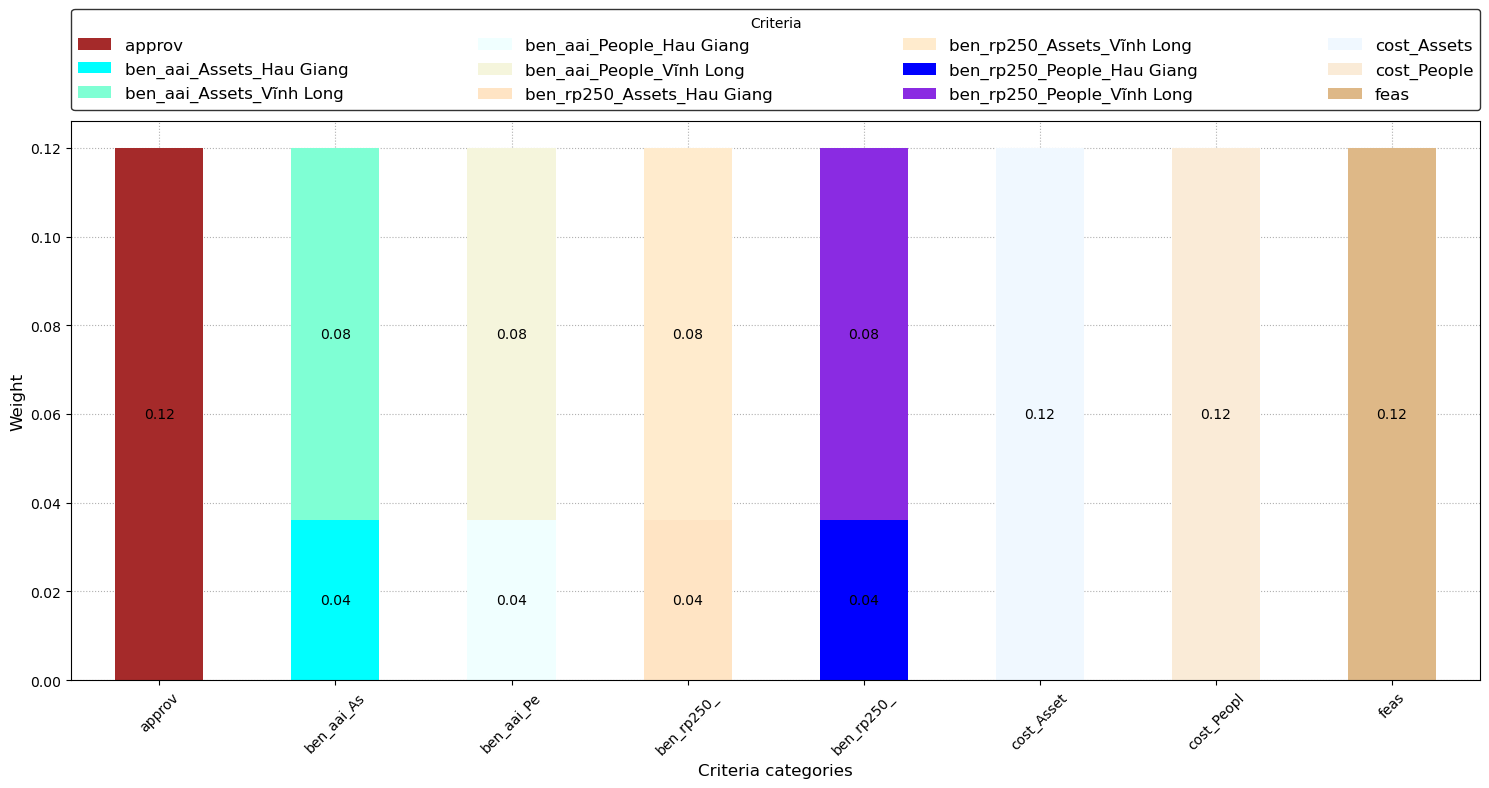

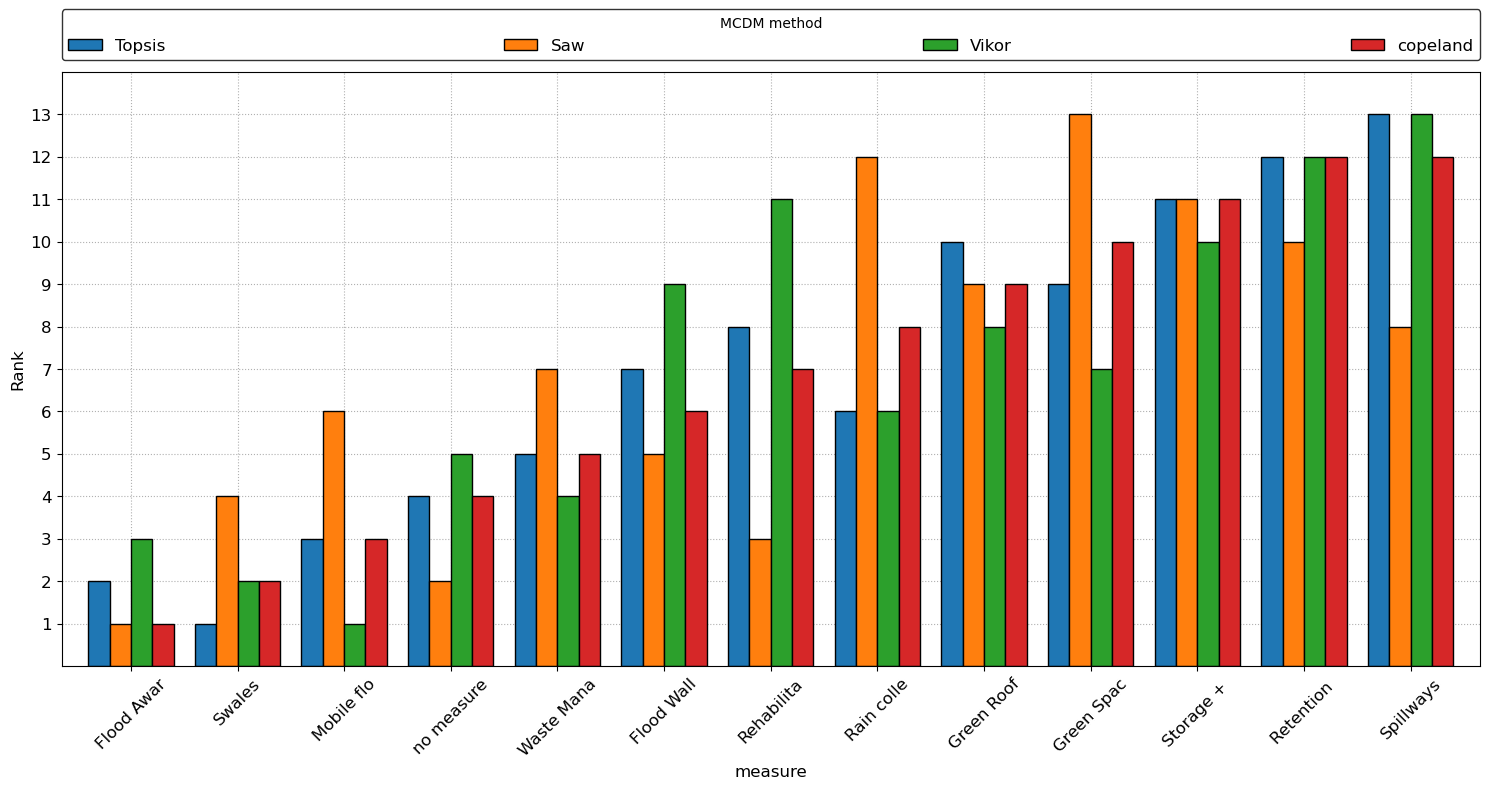

In [26]:
# *************** User-modifiable parameters ***************

group_by_category = True # Select True if the criteria should be grouped by category

# *************** End of user-modifiable parameters ***************


# Or you can create a new decision matrix object with the groups as alternatives and the criteria as the alternatives
dm_piv = dm_groups.pivot_and_reweight_criteria(piv_col='admin1_info')

# Plot the criteria weights
dm_piv.plot_criteria_weights(group_by_category=group_by_category)

# Rank the groups
ranks_output = dm_piv.calc_rankings()

# Print the rankings
ranks_output.plot_ranks(sort_by_col='copeland', alt_name_col='measure')
